# COGS 108 - EDA Checkpoint

# Names

- Kai Yui Yeung
- Haixin Chen
- Zhilin Kong
- Tony Bao
- Xiaofan Mu

<a id='research_question'></a>
# Research Question

*Can we find a linear corelation of electric vehicles' electricity efficiency (Wh/km, a response variable) and explanatory variables such as weight, power, the efficiency under diffenrent situation(see below for further explanation), and so on. We will be using the data collected for multiple car companies. Hence, given x km, we can estimate the amount of electricity, in terms of Wh, that we need to charge.*

### Dataset(s)
- Dataset updated time: 2022/11/20
- Dataset Name: Electric Vehicle Database
- Link to the dataset: https://ev-database.org/

The Electric Vehicle Database gathers official data in addition to real world data. Because theoretical data gathered in laboratories may not always be applicable in practice. Since we do not know how to use web scraping, we manually input all the data.
The dataset includes energy consumption and 16 aspects of automotive design and performance for 65 electric vehicles(will add more vehicles and variables in the future, e.g., City - Cold Weather).

1. Brand: the brand of the car.
2. Model: the model of the car.
3. Usable Battery: battery capacity in Wh.
4. Acceleration: the time in seconds from 0 to 100km/h.
5. Battery Type: the type of battery.
6. Drive: Front, Rear, and all-wheel drive(AWD).
7. Electric Range: the estimate range(km) for a vehicle.
8. Total Power: the output of motors(kw).
9. Total Torque: the torque of the vehicle(Nm).
10. Efficiency/Energy Consumption Ratio(ECR): Usable Battery divided by Electric Range (Wh/km).
11. Towing Weight: the total weight a car can tow(kg).
12. Gross Vehicle Weight: the estimate weight(kg) with everything in it such as passengers, luggage and other cargo.
13. Weight Unladen(EU): the net weight of the vehicle.
14. Number of seats: the number of seats.

**Below is the indication of real-world range in several situations. The actual range will depend on speed, style of driving, weather and route conditions.**

15. City - Cold Weather (km): Cold weather: 'worst-case' based on -10°C and use of heating. 
16. City - Mild Weather (km): Mild weather: 'best-case' based on 23°C and no use of A/C. 
17. Highway - Cold Weather (km): Cold weather: 'worst-case' based on -10°C and use of heating. For 'Highway' figures a constant speed of 110 km/h is assumed. 
18. Highway - Mild Weather (km): Mild weather: 'best-case' based on 23°C and no use of A/C. For 'Highway' figures a constant speed of 110 km/h is assumed.

**Indication of real-world energy use in several situations.**

19. Combined - Cold Weather: the estimation of real energy consumption(Wh/km) under 'worst-case' (-10°C) and use of heating. 'combined' means combining both city and highway situation.
20. Combined - Mild Weather: the estimation of real energy consumption(Wh/km) under 'best-case'(23°C) and no use of A/C. 'combined' means combining both city and highway situation.

# Setup

In [14]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

import seaborn as sns
sns.set()
sns.set_context('talk')

import warnings
warnings.filterwarnings('ignore')

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

sns.set(rc={'figure.figsize':(15,10)})

# Data Cleaning

### Load the data

In [15]:
df = pd.read_csv('EV_cars_final.csv')
df

Brand                          Model  City - Cold Weather (km)  \
0      Tesla  Model 3 Long Range Dual Motor                     455.0   
1      Tesla  Model Y Long Range Dual Motor                     420.0   
2      Tesla                        Model 3                     360.0   
3         MG            MG4 Electric 64 kWh                     355.0   
4      Honda                      e Advance                     165.0   
..       ...                            ...                       ...   
60        MG               ZS EV Long Range                     370.0   
61        MG            MG4 Electric 51 kWh                     295.0   
62  Polestar        2 Long Range Dual Motor                     385.0   
63       NIO                     ET7 100kWh                     475.0   
64     Tesla                  Model S Plaid                     515.0   

    City - Mild Weather (km)  Highway - Cold Weather (km)  \
0                      700.0                        350.0   
1                      635.0                        315.0   
2                      555.0                        275.0   
3                      535.0                        260.0   
4                      255.0                        125.0   
..                       ...                          ...   
60                     550.0                        255.0   
61                     445.0                        215.0   
62                     565.0                        280.0   
63                     705.0                        370.0   
64                     765.0                        395.0   

    Highway - Mild Weather (km)  Useable Battery(Wh)  \
0                         460.0                75000   
1                         405.0                75000   
2                         360.0                57500   
3                         335.0                61700   
4                         155.0                28500   
..                          ...                  ...   
60                        325.0                68300   
61                        275.0                50800   
62                        360.0                75000   
63                        480.0                90000   
64                        515.0                95000   

    Combined - Cold Weather(Wh/km)  Combined -Mild Weather(Wh/km)  \
0                              188                            134   
1                              205                            149   
2                              183                            129   
3                              202                            147   
4                              204                            146   
..                             ...                            ...   
60                             220                            165   
61                             199                            147   
62                             224                            165   
63                             212                            155   
64                             209                            152   

    Acceleration(0-100km/h) Battery Type  Drive  Electric Range(km)  \
0                       4.4  Lithium-ion    AWD                 485   
1                       5.0  Lithium-ion    AWD                 435   
2                       6.1  Lithium-ion   Rear                 380   
3                       7.9  Lithium-ion   Rear                 365   
4                       9.0  Lithium-ion   Rear                 170   
..                      ...          ...    ...                 ...   
60                      8.4  Lithium-ion  Front                 365   
61                      7.7  Lithium-ion   Rear                 300   
62                      4.7  Lithium-ion    AWD                 395   
63                      3.8  Lithium-ion    AWD                 505   
64                      2.1  Lithium-ion    AWD                 540   

    Total Power(kw)  Total Torque(Nm)  Eff

### Data Wrangling
Cleaning the dataset.Dropping the data with no answers. There are some datas that we do not want in our analysis.

In [16]:
# Drop row that has all NaN values
df=df.dropna(how='all')
# Drop rows that has NaN values on selected columns
clean_df=df.dropna(subset=['City - Cold Weather (km)','City - Mild Weather (km)','Highway - Cold Weather (km)','Highway - Mild Weather (km)'])
clean_df

Brand                          Model  City - Cold Weather (km)  \
0            Tesla  Model 3 Long Range Dual Motor                     455.0   
1            Tesla  Model Y Long Range Dual Motor                     420.0   
2            Tesla                        Model 3                     360.0   
3               MG            MG4 Electric 64 kWh                     355.0   
4            Honda                      e Advance                     165.0   
5              BMW                         iX M60                     480.0   
6              BMW                    I4 eDrive40                     445.0   
7              BMW                   iX1 xDrive30                     345.0   
8              BMW                    iX xDrive40                     350.0   
9              BMW                    iX xDrive50                     500.0   
10             BMW                         i4 M50                     420.0   
11             BMW                    i7 xDrive60                     490.0   
12             BMW                            iX3                     385.0   
13            Audi                   e-tron GT RS                     395.0   
14            Audi                   Q4 e-tron 40                     405.0   
15            Audi              e-tron 55 quattro                     510.0   
16            Audi                   Q4 e-tron 35                     280.0   
18         Hyundai         IONIQ 5 Long Range AWD                     380.0   
19         Hyundai     IONIQ 5 Standard Range 2WD                     295.0   
20          Jaguar                   I-Pace EV400                     390.0   
21             Kia                        Niro EV                     375.0   
22             Kia             EV6 Long Range AWD                     395.0   
23             Kia                  e-Soul 64 kWh                     365.0   
24           Mazda                          MX-30                     170.0   
25         Peugeot                          e-208                     280.0   
26         Peugeot           e-Rifter Long 50 kWh                     205.0   
28          Skouda                    Enyaq iV 80                     415.0   
29          Skouda              Enyaq Coupe iV RS                     395.0   
31          Toyota                       bZ4X AWD                     365.0   
32          Toyota          PROACE Verso L 75 kWh                     280.0   
33          Toyota        PROACE Shuttle L 50 kWh                     190.0   
34         Porsche                 Taycan Turbo s                     390.0   
35         Porsche                      Taycan 4s                     375.0   
36         Porsche                        Taycan                      390.0   
37      Volkswagen                    ID.Buzz Pro                     340.0   
38      Volkswagen           ID.4 Pro Performance                     405.0   
39      Volkswagen                       ID.5 GTX                     400.0   
42        Mercedes                   EQV 300 Long                     330.0   
43        Mercedes              EQE AMG 43 4MATIC                     465.0   
44        Mercedes                        EQA 250                     350.0   
45        Mercedes                 EQA 300 4MATIC                     345.0   
46        Citroen                            e-C4                     265.0   
47        Citroen             e-Berlingo M 50 kWh                     215.0   
48        Citroen          e-Jumpy Combi M 50 kWh                     190.0   
49           CUPRA           Born 170 kW - 77 kWh                     435.0   
50        Mercedes                       EQE 350+                     500.0   
51        Mercedes                       EQS 450+                     595.0   
52             Kia                         EV6 GT                     365.0   
53  Renault Megane              E-Tech EV60 220hp                     350.0   
54        Mercedes             EQS AMG 53 4MATIC+              

Rename columns

In [18]:
clean_df = clean_df.rename(columns={"City - Cold Weather (km)" : "City-Cold(km)",
                        "City - Mild Weather (km)" : "City-Mild(km)",
                        "Highway - Cold Weather (km)" : "Highway-Cold(km)",
                        "Highway - Mild Weather (km)" : "Highway-Mild(km)",
                        "Useable Battery(Wh)": "Battery", 
                        "Combined - Cold Weather(Wh/km)": "Combined-Cold",
                        "Combined -Mild Weather(Wh/km)" : "Combined-Mild",
                        "Acceleration(0-100km/h)" : "Acceleration",
                        "Electric Range(km)" : "Range",
                        "Total Power(kw)" : "Power",
                        "Total Torque(Nm)" : "Torque",
                        "Efficiency(Wh/km)" : "ECR",
                        "Towing Weight(kg)" : "Towing",
                        "Gross Vehicle Weight(kg)" : "Weight",
                        "Weight Unladen(EU)" : "Weight Unladen",
                        "Number of seats" : "seats"})
clean_df

Brand                          Model  City-Cold(km)  \
0            Tesla  Model 3 Long Range Dual Motor          455.0   
1            Tesla  Model Y Long Range Dual Motor          420.0   
2            Tesla                        Model 3          360.0   
3               MG            MG4 Electric 64 kWh          355.0   
4            Honda                      e Advance          165.0   
5              BMW                         iX M60          480.0   
6              BMW                    I4 eDrive40          445.0   
7              BMW                   iX1 xDrive30          345.0   
8              BMW                    iX xDrive40          350.0   
9              BMW                    iX xDrive50          500.0   
10             BMW                         i4 M50          420.0   
11             BMW                    i7 xDrive60          490.0   
12             BMW                            iX3          385.0   
13            Audi                   e-tron GT RS          395.0   
14            Audi                   Q4 e-tron 40          405.0   
15            Audi              e-tron 55 quattro          510.0   
16            Audi                   Q4 e-tron 35          280.0   
18         Hyundai         IONIQ 5 Long Range AWD          380.0   
19         Hyundai     IONIQ 5 Standard Range 2WD          295.0   
20          Jaguar                   I-Pace EV400          390.0   
21             Kia                        Niro EV          375.0   
22             Kia             EV6 Long Range AWD          395.0   
23             Kia                  e-Soul 64 kWh          365.0   
24           Mazda                          MX-30          170.0   
25         Peugeot                          e-208          280.0   
26         Peugeot           e-Rifter Long 50 kWh          205.0   
28          Skouda                    Enyaq iV 80          415.0   
29          Skouda              Enyaq Coupe iV RS          395.0   
31          Toyota                       bZ4X AWD          365.0   
32          Toyota          PROACE Verso L 75 kWh          280.0   
33          Toyota        PROACE Shuttle L 50 kWh          190.0   
34         Porsche                 Taycan Turbo s          390.0   
35         Porsche                      Taycan 4s          375.0   
36         Porsche                        Taycan           390.0   
37      Volkswagen                    ID.Buzz Pro          340.0   
38      Volkswagen           ID.4 Pro Performance          405.0   
39      Volkswagen                       ID.5 GTX          400.0   
42        Mercedes                   EQV 300 Long          330.0   
43        Mercedes              EQE AMG 43 4MATIC          465.0   
44        Mercedes                        EQA 250          350.0   
45        Mercedes                 EQA 300 4MATIC          345.0   
46        Citroen                            e-C4          265.0   
47        Citroen             e-Berlingo M 50 kWh          215.0   
48        Citroen          e-Jumpy Combi M 50 kWh          190.0   
49           CUPRA           Born 170 kW - 77 kWh          435.0   
50        Mercedes                       EQE 350+          500.0   
51        Mercedes                       EQS 450+          595.0   
52             Kia                         EV6 GT          365.0   
53  Renault Megane              E-Tech EV60 220hp          350.0   
54        Mercedes             EQS AMG 53 4MATIC+          535.0   
55          Nissan                    Ariya 87kWh          450.0   
56        Mercedes                 EQC 400 4MATIC          370.0   
57        Mercedes                 EQB 350 4MATIC          330.0   
58           Volvo    XC40 Recharge Pure Electric          340.0   
59           Tesla            Model Y Performance          405.0   
60              MG               ZS EV Long Range          370.0   
61              MG            MG4 Electric 51 kWh          295.0   
62        Polestar        2 Long Range Dual Motor          385.0   
6

Drop unnecessary columns. Drop the seats column since seats may not effect or even make our predicted formula worse. For example, for Tesla Model X, we can choose 5/6/7 seats for the same Model X. Therefore, 'seats' should be dropped. 'Battery Type' should be dropped since all battery Types are Lithium-ion.

In [19]:
clean_df = clean_df.drop(columns = ['seats','Battery Type'])
clean_df

Brand                          Model  City-Cold(km)  \
0            Tesla  Model 3 Long Range Dual Motor          455.0   
1            Tesla  Model Y Long Range Dual Motor          420.0   
2            Tesla                        Model 3          360.0   
3               MG            MG4 Electric 64 kWh          355.0   
4            Honda                      e Advance          165.0   
5              BMW                         iX M60          480.0   
6              BMW                    I4 eDrive40          445.0   
7              BMW                   iX1 xDrive30          345.0   
8              BMW                    iX xDrive40          350.0   
9              BMW                    iX xDrive50          500.0   
10             BMW                         i4 M50          420.0   
11             BMW                    i7 xDrive60          490.0   
12             BMW                            iX3          385.0   
13            Audi                   e-tron GT RS          395.0   
14            Audi                   Q4 e-tron 40          405.0   
15            Audi              e-tron 55 quattro          510.0   
16            Audi                   Q4 e-tron 35          280.0   
18         Hyundai         IONIQ 5 Long Range AWD          380.0   
19         Hyundai     IONIQ 5 Standard Range 2WD          295.0   
20          Jaguar                   I-Pace EV400          390.0   
21             Kia                        Niro EV          375.0   
22             Kia             EV6 Long Range AWD          395.0   
23             Kia                  e-Soul 64 kWh          365.0   
24           Mazda                          MX-30          170.0   
25         Peugeot                          e-208          280.0   
26         Peugeot           e-Rifter Long 50 kWh          205.0   
28          Skouda                    Enyaq iV 80          415.0   
29          Skouda              Enyaq Coupe iV RS          395.0   
31          Toyota                       bZ4X AWD          365.0   
32          Toyota          PROACE Verso L 75 kWh          280.0   
33          Toyota        PROACE Shuttle L 50 kWh          190.0   
34         Porsche                 Taycan Turbo s          390.0   
35         Porsche                      Taycan 4s          375.0   
36         Porsche                        Taycan           390.0   
37      Volkswagen                    ID.Buzz Pro          340.0   
38      Volkswagen           ID.4 Pro Performance          405.0   
39      Volkswagen                       ID.5 GTX          400.0   
42        Mercedes                   EQV 300 Long          330.0   
43        Mercedes              EQE AMG 43 4MATIC          465.0   
44        Mercedes                        EQA 250          350.0   
45        Mercedes                 EQA 300 4MATIC          345.0   
46        Citroen                            e-C4          265.0   
47        Citroen             e-Berlingo M 50 kWh          215.0   
48        Citroen          e-Jumpy Combi M 50 kWh          190.0   
49           CUPRA           Born 170 kW - 77 kWh          435.0   
50        Mercedes                       EQE 350+          500.0   
51        Mercedes                       EQS 450+          595.0   
52             Kia                         EV6 GT          365.0   
53  Renault Megane              E-Tech EV60 220hp          350.0   
54        Mercedes             EQS AMG 53 4MATIC+          535.0   
55          Nissan                    Ariya 87kWh          450.0   
56        Mercedes                 EQC 400 4MATIC          370.0   
57        Mercedes                 EQB 350 4MATIC          330.0   
58           Volvo    XC40 Recharge Pure Electric          340.0   
59           Tesla            Model Y Performance          405.0   
60              MG               ZS EV Long Range          370.0   
61              MG            MG4 Electric 51 kWh          295.0   
62        Polestar        2 Long Range Dual Motor          385.0   
6

Calculate the estimate **Real Energy Consumption** for **"City - Cold Weather (km)" , "City - Mild Weather (km)","Highway - Cold Weather (km)", and "Highway - Mild Weather (km)"**.

In [20]:
#df['City-Cold'] = clean_df[['Battery']].div(clean_df['City-Cold(km)'], axis=0)
#df1 = pd.DataFrame()
clean_df['City-Cold'] = clean_df['Battery'] / clean_df['City-Cold(km)']
clean_df['City-Mild'] = clean_df['Battery'] / clean_df['City-Mild(km)']
clean_df['Highway-Cold'] = clean_df['Battery'] / clean_df['Highway-Cold(km)']
clean_df['Highway-Mild'] = clean_df['Battery'] / clean_df['Highway-Mild(km)']
clean_df

Brand                          Model  City-Cold(km)  \
0            Tesla  Model 3 Long Range Dual Motor          455.0   
1            Tesla  Model Y Long Range Dual Motor          420.0   
2            Tesla                        Model 3          360.0   
3               MG            MG4 Electric 64 kWh          355.0   
4            Honda                      e Advance          165.0   
5              BMW                         iX M60          480.0   
6              BMW                    I4 eDrive40          445.0   
7              BMW                   iX1 xDrive30          345.0   
8              BMW                    iX xDrive40          350.0   
9              BMW                    iX xDrive50          500.0   
10             BMW                         i4 M50          420.0   
11             BMW                    i7 xDrive60          490.0   
12             BMW                            iX3          385.0   
13            Audi                   e-tron GT RS          395.0   
14            Audi                   Q4 e-tron 40          405.0   
15            Audi              e-tron 55 quattro          510.0   
16            Audi                   Q4 e-tron 35          280.0   
18         Hyundai         IONIQ 5 Long Range AWD          380.0   
19         Hyundai     IONIQ 5 Standard Range 2WD          295.0   
20          Jaguar                   I-Pace EV400          390.0   
21             Kia                        Niro EV          375.0   
22             Kia             EV6 Long Range AWD          395.0   
23             Kia                  e-Soul 64 kWh          365.0   
24           Mazda                          MX-30          170.0   
25         Peugeot                          e-208          280.0   
26         Peugeot           e-Rifter Long 50 kWh          205.0   
28          Skouda                    Enyaq iV 80          415.0   
29          Skouda              Enyaq Coupe iV RS          395.0   
31          Toyota                       bZ4X AWD          365.0   
32          Toyota          PROACE Verso L 75 kWh          280.0   
33          Toyota        PROACE Shuttle L 50 kWh          190.0   
34         Porsche                 Taycan Turbo s          390.0   
35         Porsche                      Taycan 4s          375.0   
36         Porsche                        Taycan           390.0   
37      Volkswagen                    ID.Buzz Pro          340.0   
38      Volkswagen           ID.4 Pro Performance          405.0   
39      Volkswagen                       ID.5 GTX          400.0   
42        Mercedes                   EQV 300 Long          330.0   
43        Mercedes              EQE AMG 43 4MATIC          465.0   
44        Mercedes                        EQA 250          350.0   
45        Mercedes                 EQA 300 4MATIC          345.0   
46        Citroen                            e-C4          265.0   
47        Citroen             e-Berlingo M 50 kWh          215.0   
48        Citroen          e-Jumpy Combi M 50 kWh          190.0   
49           CUPRA           Born 170 kW - 77 kWh          435.0   
50        Mercedes                       EQE 350+          500.0   
51        Mercedes                       EQS 450+          595.0   
52             Kia                         EV6 GT          365.0   
53  Renault Megane              E-Tech EV60 220hp          350.0   
54        Mercedes             EQS AMG 53 4MATIC+          535.0   
55          Nissan                    Ariya 87kWh          450.0   
56        Mercedes                 EQC 400 4MATIC          370.0   
57        Mercedes                 EQB 350 4MATIC          330.0   
58           Volvo    XC40 Recharge Pure Electric          340.0   
59           Tesla            Model Y Performance          405.0   
60              MG               ZS EV Long Range          370.0   
61              MG            MG4 Electric 51 kWh          295.0   
62        Polestar        2 Long Range Dual Motor          385.0   
6

Convert all columns with unit(Wh/km) and Range(km) to integer type.

In [21]:
clean_df = clean_df.astype({"ECR" : 'int',
                            "Combined-Cold":'int', 
                            "Combined-Mild":'int', 
                            'City-Cold':'int', 
                            'City-Mild':'int',
                            'Highway-Cold':'int',
                            'Highway-Mild':'int',
                            'Range':'int'}) 
clean_df

Brand                          Model  City-Cold(km)  \
0            Tesla  Model 3 Long Range Dual Motor          455.0   
1            Tesla  Model Y Long Range Dual Motor          420.0   
2            Tesla                        Model 3          360.0   
3               MG            MG4 Electric 64 kWh          355.0   
4            Honda                      e Advance          165.0   
5              BMW                         iX M60          480.0   
6              BMW                    I4 eDrive40          445.0   
7              BMW                   iX1 xDrive30          345.0   
8              BMW                    iX xDrive40          350.0   
9              BMW                    iX xDrive50          500.0   
10             BMW                         i4 M50          420.0   
11             BMW                    i7 xDrive60          490.0   
12             BMW                            iX3          385.0   
13            Audi                   e-tron GT RS          395.0   
14            Audi                   Q4 e-tron 40          405.0   
15            Audi              e-tron 55 quattro          510.0   
16            Audi                   Q4 e-tron 35          280.0   
18         Hyundai         IONIQ 5 Long Range AWD          380.0   
19         Hyundai     IONIQ 5 Standard Range 2WD          295.0   
20          Jaguar                   I-Pace EV400          390.0   
21             Kia                        Niro EV          375.0   
22             Kia             EV6 Long Range AWD          395.0   
23             Kia                  e-Soul 64 kWh          365.0   
24           Mazda                          MX-30          170.0   
25         Peugeot                          e-208          280.0   
26         Peugeot           e-Rifter Long 50 kWh          205.0   
28          Skouda                    Enyaq iV 80          415.0   
29          Skouda              Enyaq Coupe iV RS          395.0   
31          Toyota                       bZ4X AWD          365.0   
32          Toyota          PROACE Verso L 75 kWh          280.0   
33          Toyota        PROACE Shuttle L 50 kWh          190.0   
34         Porsche                 Taycan Turbo s          390.0   
35         Porsche                      Taycan 4s          375.0   
36         Porsche                        Taycan           390.0   
37      Volkswagen                    ID.Buzz Pro          340.0   
38      Volkswagen           ID.4 Pro Performance          405.0   
39      Volkswagen                       ID.5 GTX          400.0   
42        Mercedes                   EQV 300 Long          330.0   
43        Mercedes              EQE AMG 43 4MATIC          465.0   
44        Mercedes                        EQA 250          350.0   
45        Mercedes                 EQA 300 4MATIC          345.0   
46        Citroen                            e-C4          265.0   
47        Citroen             e-Berlingo M 50 kWh          215.0   
48        Citroen          e-Jumpy Combi M 50 kWh          190.0   
49           CUPRA           Born 170 kW - 77 kWh          435.0   
50        Mercedes                       EQE 350+          500.0   
51        Mercedes                       EQS 450+          595.0   
52             Kia                         EV6 GT          365.0   
53  Renault Megane              E-Tech EV60 220hp          350.0   
54        Mercedes             EQS AMG 53 4MATIC+          535.0   
55          Nissan                    Ariya 87kWh          450.0   
56        Mercedes                 EQC 400 4MATIC          370.0   
57        Mercedes                 EQB 350 4MATIC          330.0   
58           Volvo    XC40 Recharge Pure Electric          340.0   
59           Tesla            Model Y Performance          405.0   
60              MG               ZS EV Long Range          370.0   
61              MG            MG4 Electric 51 kWh          295.0   
62        Polestar        2 Long Range Dual Motor          385.0   
6

Rearrange the columns order, and drop the range estimation columns in diffenrent situations.

In [22]:
order = ['Brand','Model','Range','ECR','Combined-Cold','Combined-Mild','City-Cold','City-Mild','Highway-Cold','Highway-Mild',
                   'Battery','Acceleration','Drive','Power','Torque','Towing','Weight','Weight Unladen']
final_df = clean_df[order]
final_df

Brand                          Model  Range  ECR  Combined-Cold  \
0            Tesla  Model 3 Long Range Dual Motor    485  154            188   
1            Tesla  Model Y Long Range Dual Motor    435  172            205   
2            Tesla                        Model 3    380  151            183   
3               MG            MG4 Electric 64 kWh    365  169            202   
4            Honda                      e Advance    170  167            204   
5              BMW                         iX M60    485  216            257   
6              BMW                    I4 eDrive40    470  171            207   
7              BMW                   iX1 xDrive30    355  182            216   
8              BMW                    iX xDrive40    360  197            233   
9              BMW                    iX xDrive50    505  208            245   
10             BMW                         i4 M50    435  185            218   
11             BMW                    i7 xDrive60    510  199            237   
12             BMW                            iX3    385  192            228   
13            Audi                   e-tron GT RS    405  209            246   
14            Audi                   Q4 e-tron 40    405  189            222   
15            Audi              e-tron 55 quattro    365  236            275   
16            Audi                   Q4 e-tron 35    285  182            217   
18         Hyundai         IONIQ 5 Long Range AWD    385  192            228   
19         Hyundai     IONIQ 5 Standard Range 2WD    295  183            216   
20          Jaguar                   I-Pace EV400    380  222            261   
21             Kia                        Niro EV    380  170            203   
22             Kia             EV6 Long Range AWD    400  185            218   
23             Kia                  e-Soul 64 kWh    370  172            206   
24           Mazda                          MX-30    170  176            214   
25         Peugeot                          e-208    285  157            188   
26         Peugeot           e-Rifter Long 50 kWh    195  230            273   
28          Skouda                    Enyaq iV 80    420  183            217   
29          Skouda              Enyaq Coupe iV RS    405  190            226   
31          Toyota                       bZ4X AWD    370  192            230   
32          Toyota          PROACE Verso L 75 kWh    260  261            302   
33          Toyota        PROACE Shuttle L 50 kWh    175  257            300   
34         Porsche                 Taycan Turbo s    400  209            246   
35         Porsche                      Taycan 4s    395  179            212   
36         Porsche                        Taycan     410  173            206   
37      Volkswagen                    ID.Buzz Pro    330  233            270   
38      Volkswagen           ID.4 Pro Performance    410  187            220   
39      Volkswagen                       ID.5 GTX    405  190            223   
42        Mercedes                   EQV 300 Long    305  295            340   
43        Mercedes              EQE AMG 43 4MATIC    485  186            221   
44        Mercedes                        EQA 250    355  187            222   
45        Mercedes                 EQA 300 4MATIC    350  190            225   
46        Citroen                            e-C4    265  169            200   
47        Citroen             e-Berlingo M 50 kWh    200  225            257   
48        Citroen          e-Jumpy Combi M 50 kWh    180  250            290   
49           CUPRA           Born 170 kW - 77 kWh    450  171            205   
50        Mercedes                       EQE 350+    525  172            206   
51        Mercedes                       EQS 450+    640  168            201   
52             Kia                         EV6 GT    370  200            235   
53  Renault Megane              E-Tech EV60 220hp    360  166            200   
54        Mer

# Data Analysis & Results (EDA)

Carry out EDA on your dataset(s); Describe in this section

In [23]:
## YOUR CODE HERE
## FEEL FREE TO ADD MULTIPLE CELLS PER SECTION

### Decriptive Analysis
Describe the data set in order to take out the useful statistics, such as median, mean, etc. These can be used for prediction later.

In [24]:
final_df.describe()

Range         ECR  Combined-Cold  Combined-Mild   City-Cold  \
count   60.000000   60.000000      60.000000      60.000000   60.000000   
mean   378.166667  192.983333     228.466667     169.716667  193.533333   
std     98.634605   27.503153      30.036964      26.037191   21.207983   
min    170.000000  151.000000     183.000000     129.000000  159.000000   
25%    333.750000  172.750000     206.750000     151.750000  181.000000   
50%    380.000000  187.000000     221.500000     164.500000  190.000000   
75%    423.750000  200.250000     237.250000     176.250000  202.000000   
max    640.000000  295.000000     340.000000     265.000000  272.000000   

        City-Mild  Highway-Cold  Highway-Mild        Battery  Acceleration  \
count   60.000000      60.00000     60.000000      60.000000     60.000000   
mean   131.900000     268.15000    210.116667   72200.000000      6.833333   
std     18.314299      40.06978     34.586708   17869.252069      2.611102   
min    103.000000     209.00000    159.000000   28500.000000      2.100000   
25%    120.000000     240.00000    185.000000   64525.000000      4.775000   
50%    128.500000     260.50000    204.000000   74000.000000      6.450000   
75%    137.250000     277.50000    218.500000   81450.000000      8.500000   
max    202.000000     418.00000    339.000000  107800.000000     13.100000   

            Power       Torque       Towing       Weight  Weight Unladen  
count   60.000000    59.000000    60.000000    59.000000       60.000000  
mean   245.833333   487.627119   960.666667  2602.881356     2138.483333  
std    142.090705   227.901135   700.299855   358.838312      301.203771  
min    100.000000   250.000000     0.000000  1855.000000     1530.000000  
25%    150.000000   310.000000   500.000000  2295.000000     1939.250000  
50%    212.500000   400.000000   950.000000  2616.000000     2122.000000  
75%    312.500000   650.000000  1600.000000  2880.000000     2367.750000  
max    760.000000  1100.000000  2500.000000  3250.000000     2715.000000

### Exploratory Data Analysis

Explore the data graphically in order to investigate the association between features with, for example, 'Efficiency'(Wh/km) and the other features. Then, find the features such that they seem most likely to be useful in predicting 'Efficiency'(Wh/km).  

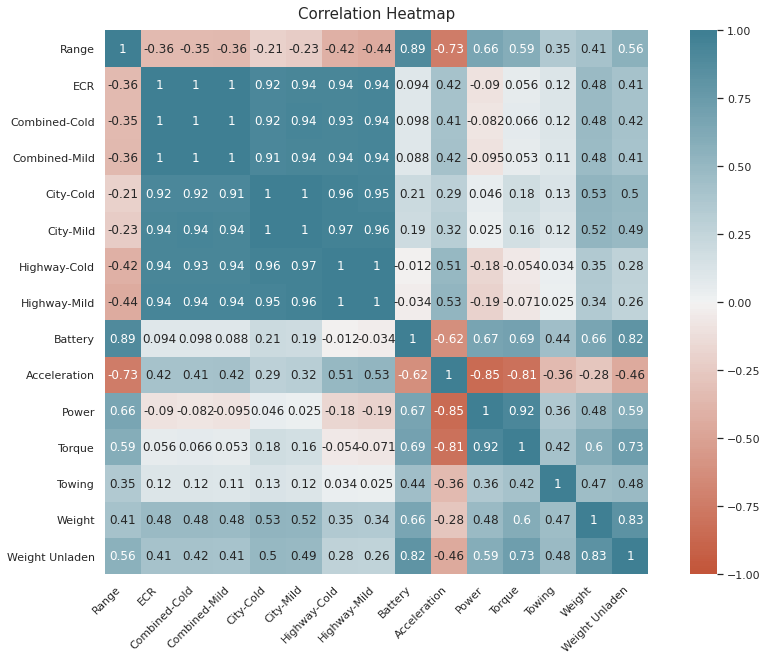

In [26]:
corr = final_df.corr()
ax = sns.heatmap(corr,
    cmap=sns.diverging_palette(20, 220, n=200),
    vmin=-1.0, vmax=1.0,center=0,
    annot = True,
    square=True)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment='right');
ax.set_title('Correlation Heatmap', fontdict={'fontsize':15}, pad=12);

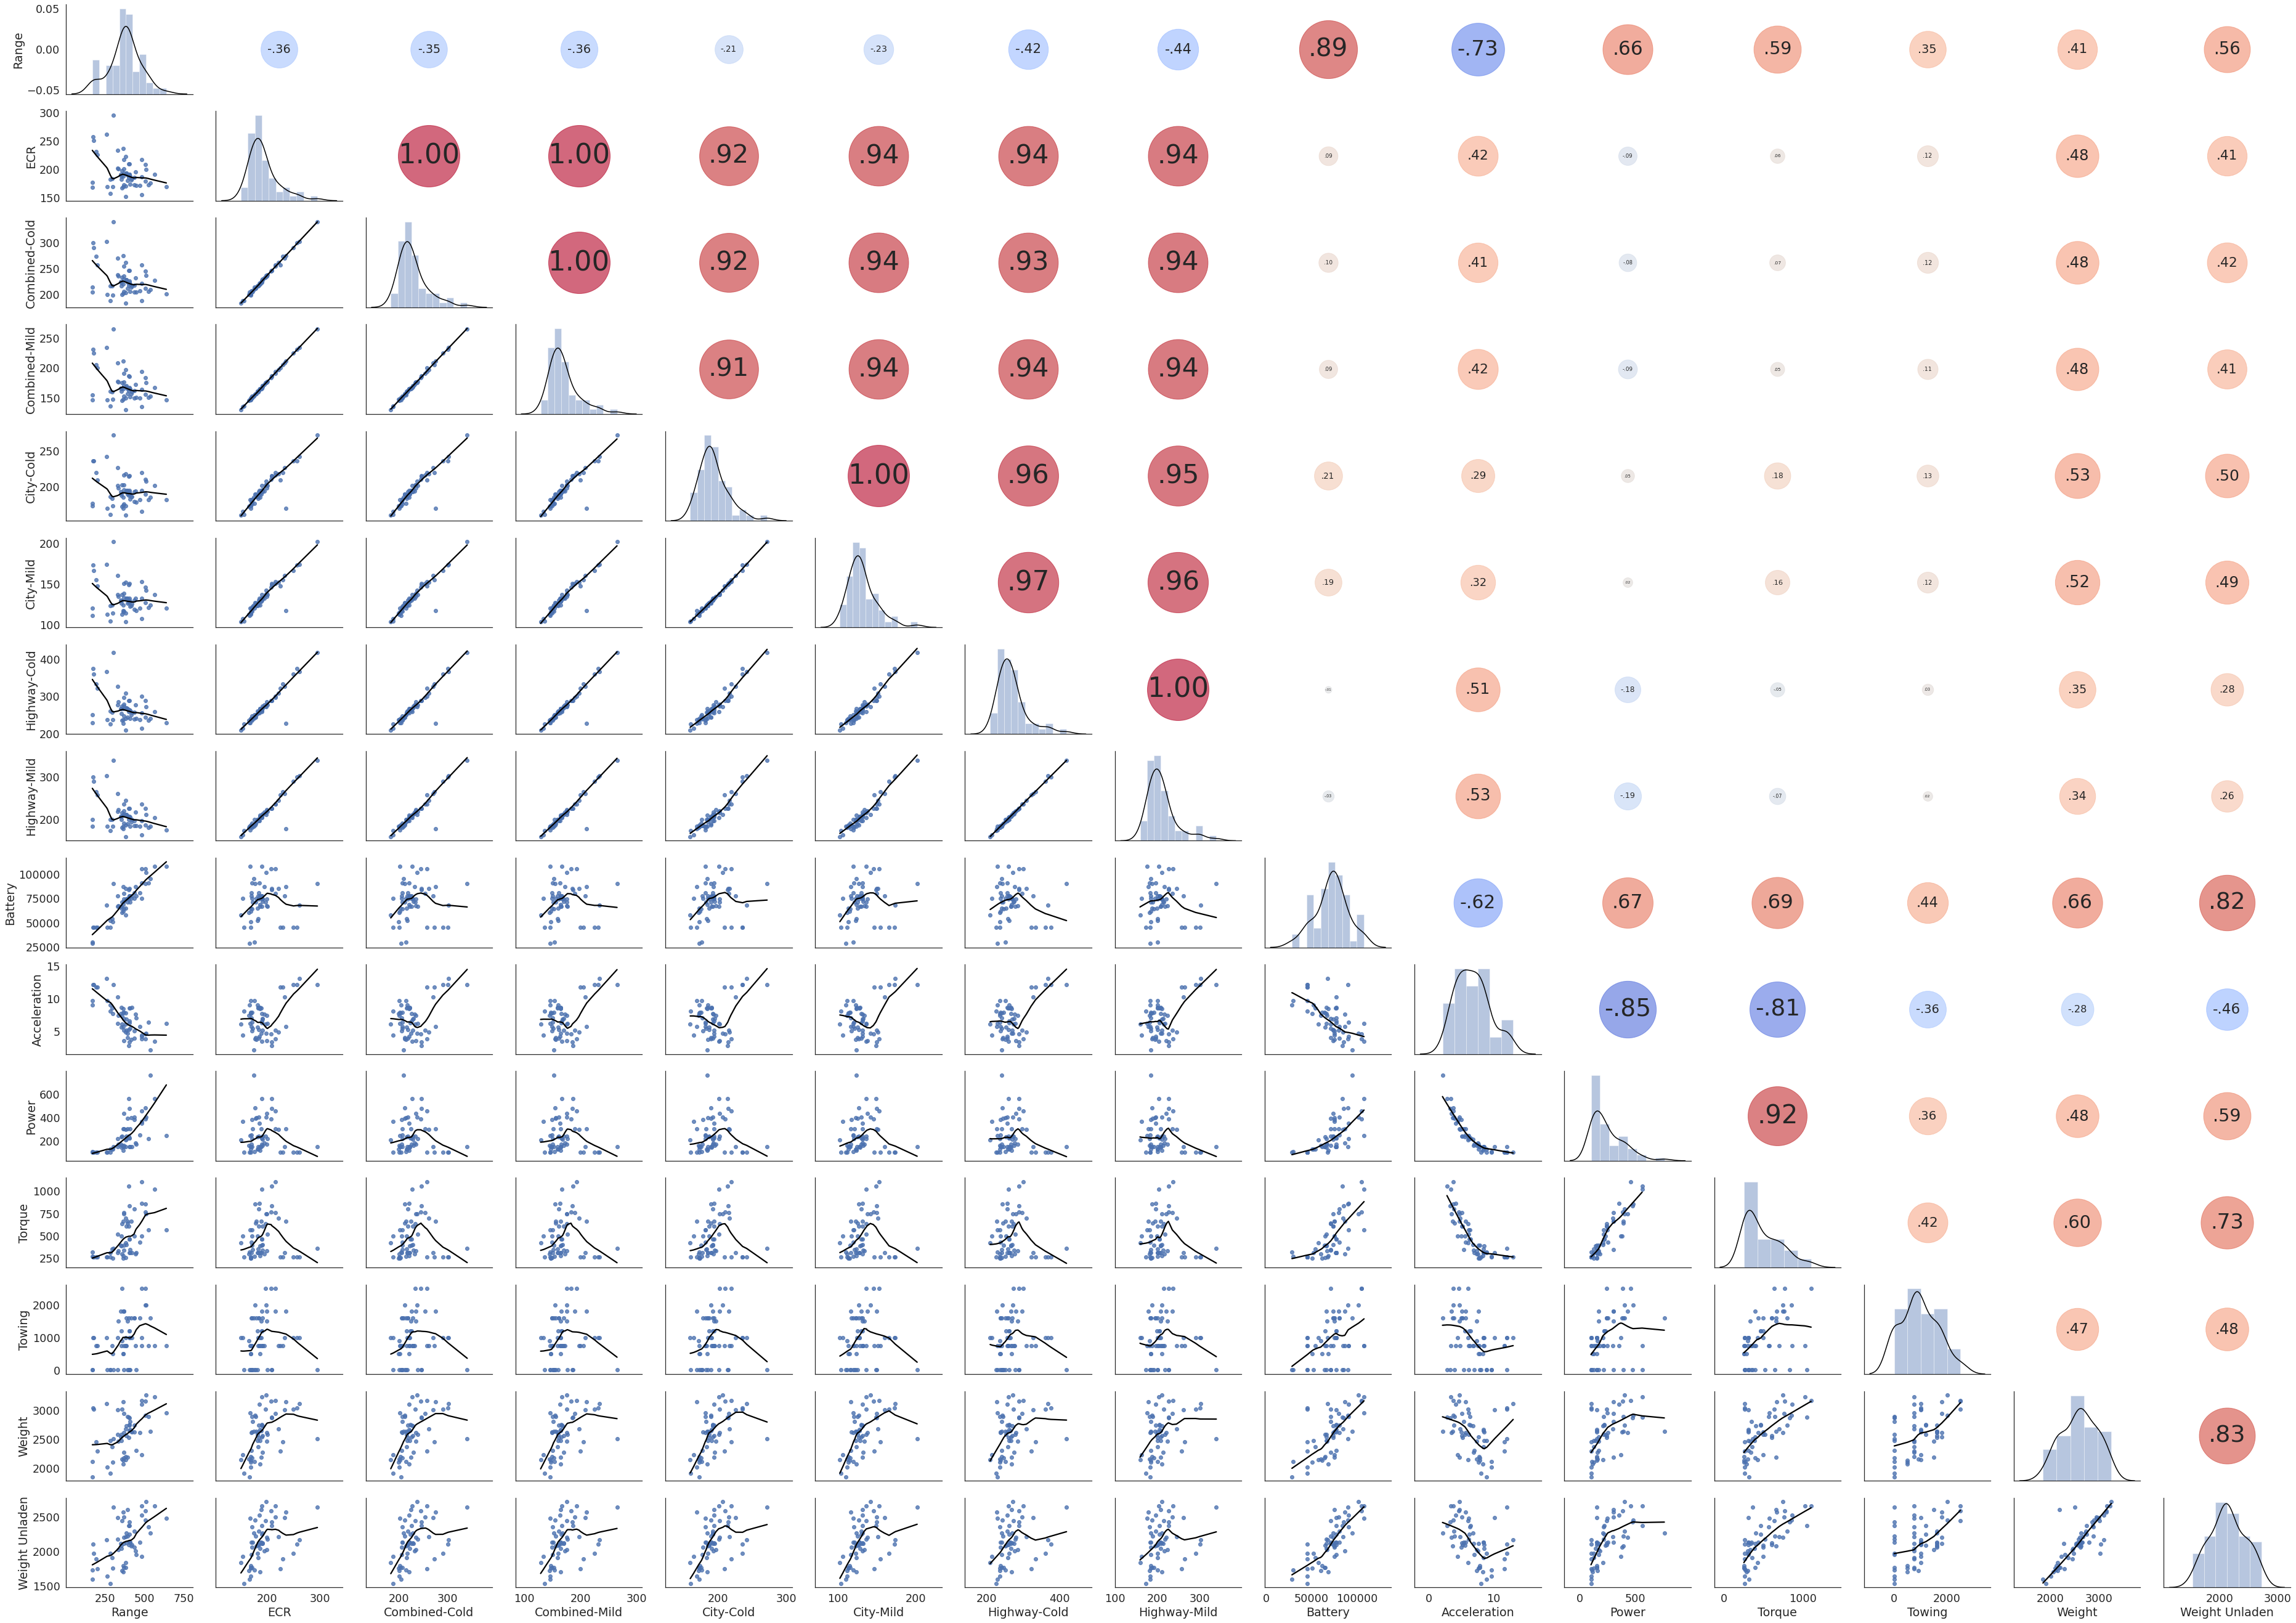

In [27]:
def corrdot(*args, **kwargs):
    corr_r = args[0].corr(args[1], 'pearson')
    corr_text = f"{corr_r:2.2f}".replace("0.", ".")
    ax = plt.gca()
    ax.set_axis_off()
    marker_size = abs(corr_r) * 10000
    ax.scatter([.5], [.5], marker_size, [corr_r], alpha=0.6, cmap="coolwarm",
               vmin=-1, vmax=1, transform=ax.transAxes)
    font_size = abs(corr_r) * 40 + 5
    ax.annotate(corr_text, [.5, .5,],  xycoords="axes fraction",
                ha='center', va='center', fontsize=font_size)

sns.set(style='white', font_scale=1.6)
#df = sns.load_dataset('final_df')
g = sns.PairGrid(final_df, aspect=1.4, diag_sharey=False)
g.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
g.map_diag(sns.distplot, kde_kws={'color': 'black'})
g.map_upper(corrdot)

It seems that there exists **multicollinearity among Efficiency, Combined-Cold, Combined-Mild, City-Cold, City-Mild, Highway-Cold, High-Mild.** Since they have very high positive correlations, i.e., if we can predict one of them, then the rest can almost be predicted by the same predictors. So redraw the graph only with 'Efficiency' and other features.

In [28]:
order = ['Brand','Model','Range','ECR','Battery','Acceleration','Drive','Power','Torque','Towing','Weight','Weight Unladen']
EDA_df = clean_df[order]
EDA_df

Brand                          Model  Range  ECR  Battery  \
0            Tesla  Model 3 Long Range Dual Motor    485  154    75000   
1            Tesla  Model Y Long Range Dual Motor    435  172    75000   
2            Tesla                        Model 3    380  151    57500   
3               MG            MG4 Electric 64 kWh    365  169    61700   
4            Honda                      e Advance    170  167    28500   
5              BMW                         iX M60    485  216   105200   
6              BMW                    I4 eDrive40    470  171    80700   
7              BMW                   iX1 xDrive30    355  182    64700   
8              BMW                    iX xDrive40    360  197    71000   
9              BMW                    iX xDrive50    505  208   105200   
10             BMW                         i4 M50    435  185    80700   
11             BMW                    i7 xDrive60    510  199   101700   
12             BMW                            iX3    385  192    74000   
13            Audi                   e-tron GT RS    405  209    85000   
14            Audi                   Q4 e-tron 40    405  189    76600   
15            Audi              e-tron 55 quattro    365  236    86500   
16            Audi                   Q4 e-tron 35    285  182    52000   
18         Hyundai         IONIQ 5 Long Range AWD    385  192    74000   
19         Hyundai     IONIQ 5 Standard Range 2WD    295  183    54000   
20          Jaguar                   I-Pace EV400    380  222    84700   
21             Kia                        Niro EV    380  170    64800   
22             Kia             EV6 Long Range AWD    400  185    74000   
23             Kia                  e-Soul 64 kWh    370  172    64000   
24           Mazda                          MX-30    170  176    30000   
25         Peugeot                          e-208    285  157    45000   
26         Peugeot           e-Rifter Long 50 kWh    195  230    45000   
28          Skouda                    Enyaq iV 80    420  183    77000   
29          Skouda              Enyaq Coupe iV RS    405  190    77000   
31          Toyota                       bZ4X AWD    370  192    71400   
32          Toyota          PROACE Verso L 75 kWh    260  261    68000   
33          Toyota        PROACE Shuttle L 50 kWh    175  257    45000   
34         Porsche                 Taycan Turbo s    400  209    83700   
35         Porsche                      Taycan 4s    395  179    71000   
36         Porsche                        Taycan     410  173    71000   
37      Volkswagen                    ID.Buzz Pro    330  233    77000   
38      Volkswagen           ID.4 Pro Performance    410  187    77000   
39      Volkswagen                       ID.5 GTX    405  190    77000   
42        Mercedes                   EQV 300 Long    305  295    90000   
43        Mercedes              EQE AMG 43 4MATIC    485  186    90600   
44        Mercedes                        EQA 250    355  187    66500   
45        Mercedes                 EQA 300 4MATIC    350  190    66500   
46        Citroen                            e-C4    265  169    45000   
47        Citroen             e-Berlingo M 50 kWh    200  225    45000   
48        Citroen          e-Jumpy Combi M 50 kWh    180  250    45000   
49           CUPRA           Born 170 kW - 77 kWh    450  171    77000   
50        Mercedes                       EQE 350+    525  172    90600   
51        Mercedes                       EQS 450+    640  168   107800   
52             Kia                         EV6 GT    370  200    74000   
53  Renault Megane              E-Tech EV60 220hp    360  166    60000   
54        Mercedes             EQS AMG 53 4MATIC+    565  190   107800   
55          Nissan                    Ariya 87kWh    445  195    87000   
56        Mercedes                 EQC 400 4MATIC    370  216    80000   
57        Mercedes                 EQB 350 4MATIC    330  201    66500   
58           Volv

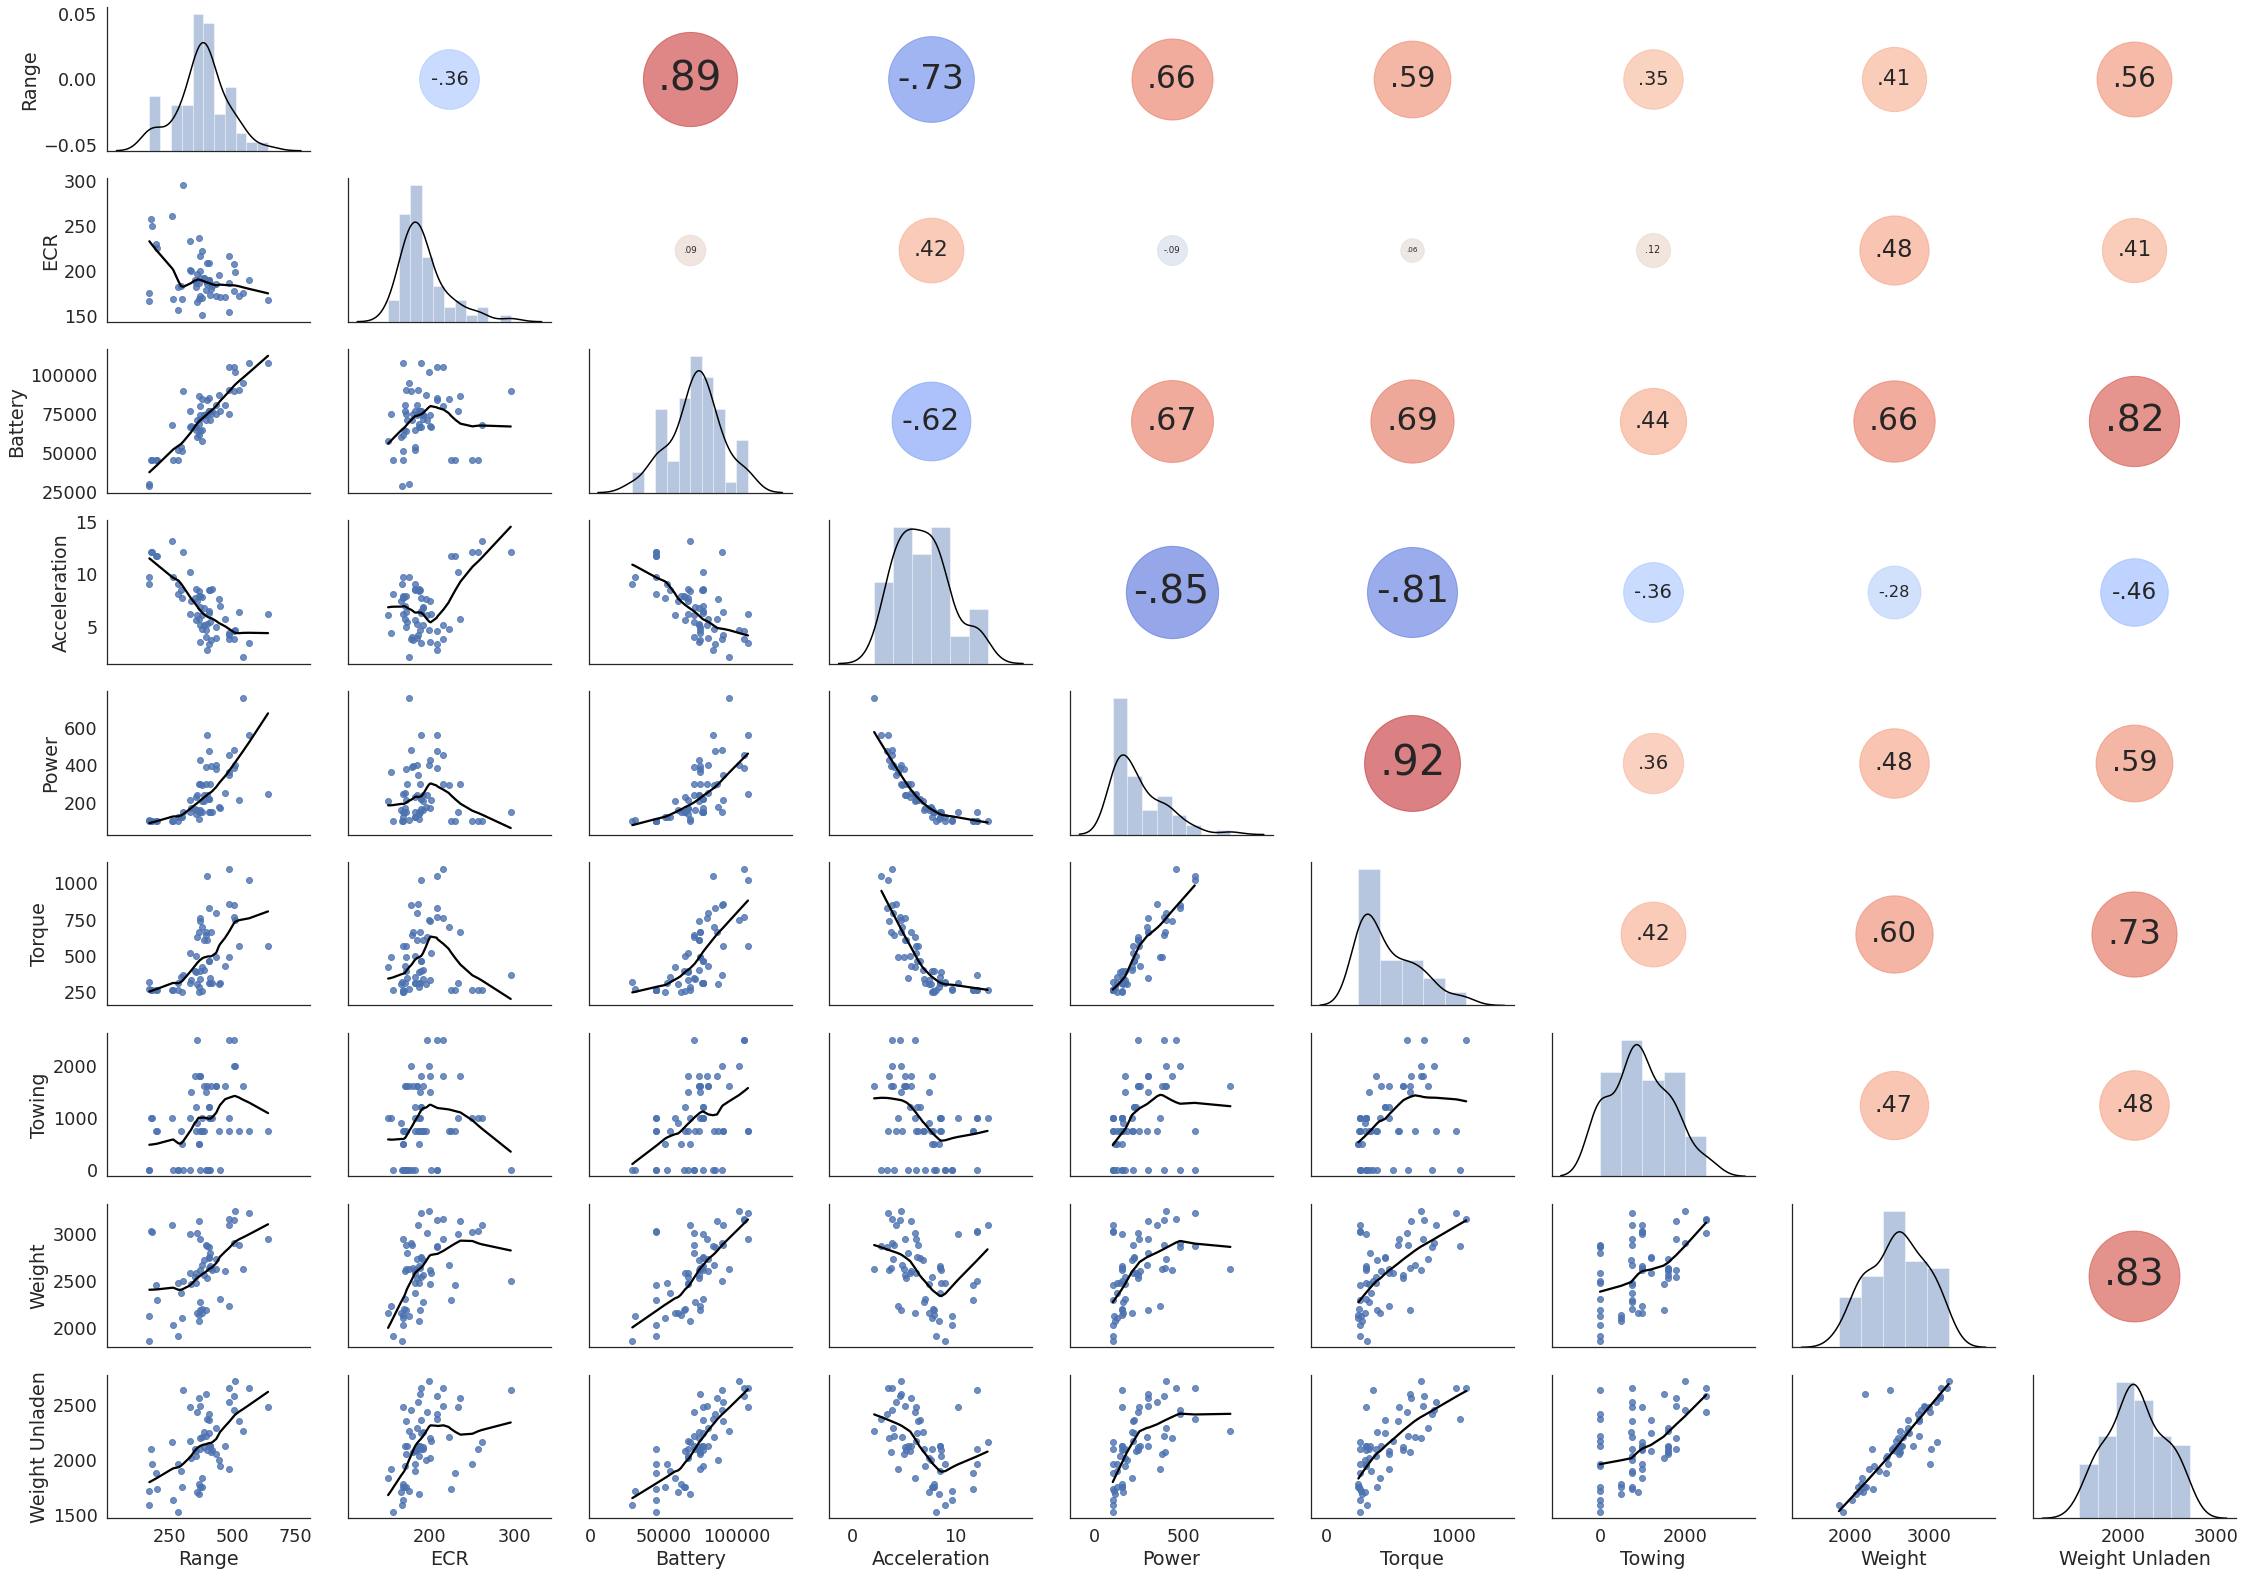

In [29]:
sns.set(style='white', font_scale=1.6)
newg = sns.PairGrid(EDA_df, aspect=1.4, diag_sharey=False)
newg.map_lower(sns.regplot, lowess=True, ci=False, line_kws={'color': 'black'})
newg.map_diag(sns.distplot, kde_kws={'color': 'black'})
newg.map_upper(corrdot)

**It seems that we'd better find a good predict line for Range rather than Efficiency. After prediciting the range, given the battery capacity, we can then calculate the efficiency.**



$\\\quad\quad Range = {\beta_0} + {\beta_1}*Battery + {\beta_2}*Acceleration + {\beta_3}*Power + {\beta_4}*Weight Unladen$

$\\\quad\quad Efficiency = \frac{Battery}{Range}=\frac{Battery}{{\beta_0} + {\beta_1} * Battery + {\beta_2} * Acceleration + {\beta_3} * Power + {\beta_4} * Weight Unladen}$

**Then, since we know variables with unit(Wh/km) have strong multicollinearity, then we can predict the efficiency under different conditions by a simple linear regression line.**

Let's look closely to the relationship between Range and Battery, Range and Acceleration, Range and Power,and Range and Weight Unladen.

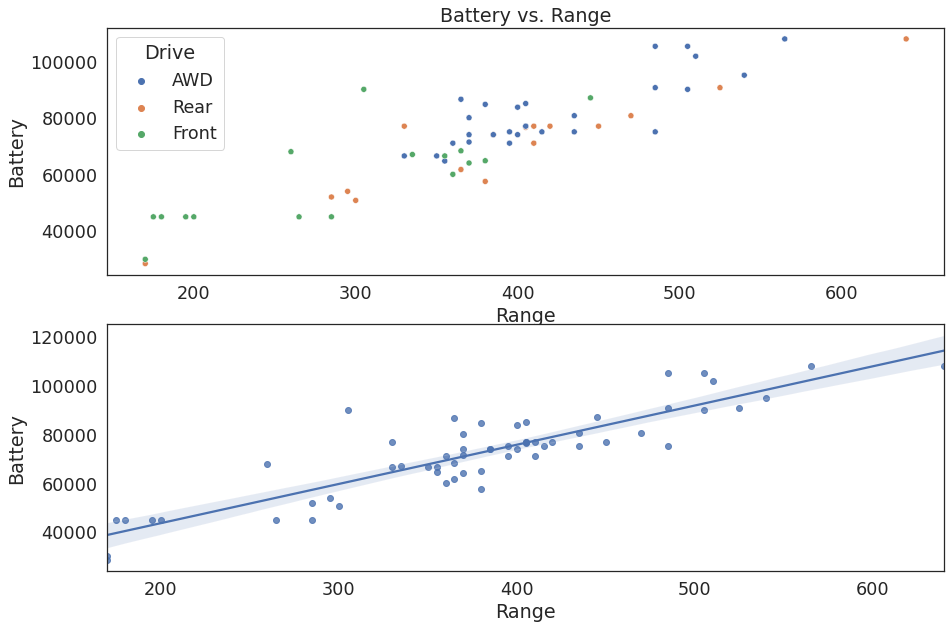

In [30]:
figure, axes = plt.subplots(nrows=2)

sns.scatterplot(data=EDA_df, 
                x='Range', 
                y='Battery',
                hue='Drive',
               sizes=(20,250),
               ax=axes[0]).set(title = 'Battery vs. Range')

sns.regplot(data=EDA_df, 
                x='Range', 
                y='Battery',
                ax=axes[1])
plt.show()

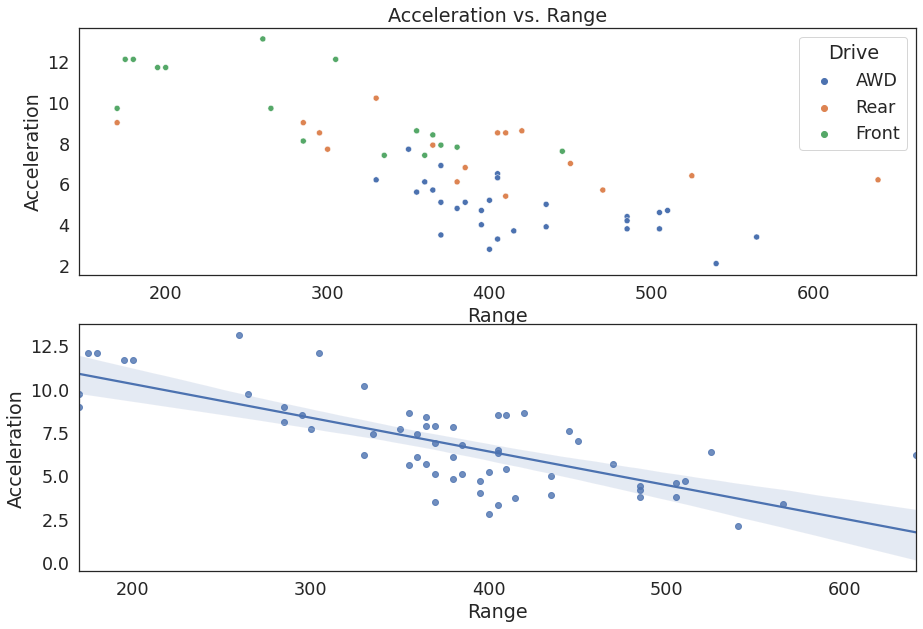

In [31]:
figure, axes = plt.subplots(nrows=2)

sns.scatterplot(data=EDA_df, 
                x='Range', 
                y='Acceleration',
                hue='Drive',
               sizes=(20,250),
               ax=axes[0]).set(title = 'Acceleration vs. Range')

sns.regplot(data=EDA_df, 
                x='Range', 
                y='Acceleration',
                ax=axes[1])
plt.show()

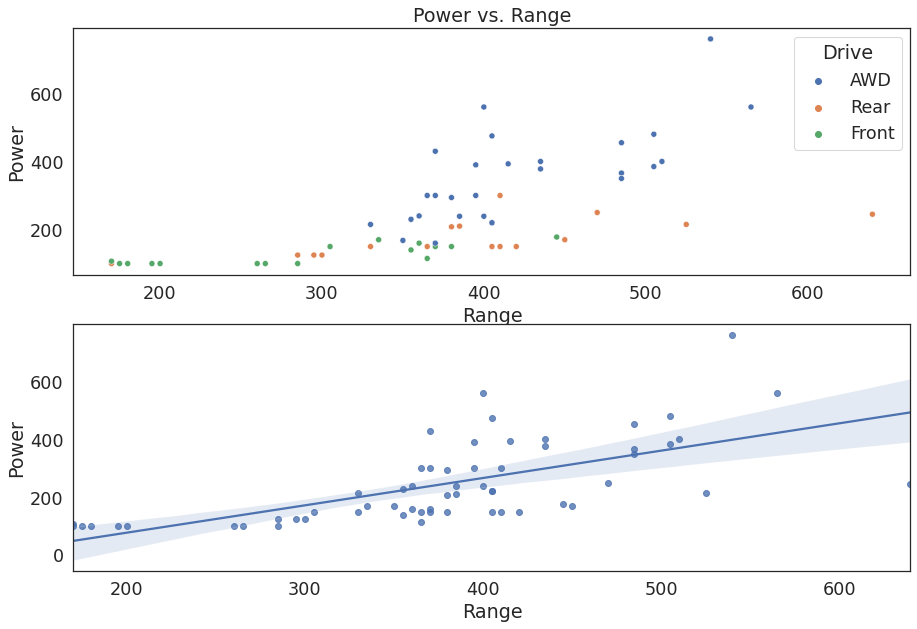

In [32]:
figure, axes = plt.subplots(nrows=2)

sns.scatterplot(data=EDA_df, 
                x='Range', 
                y='Power',
                hue='Drive',
               sizes=(20,250),
               ax=axes[0]).set(title = 'Power vs. Range')

sns.regplot(data=EDA_df, 
                x='Range', 
                y='Power',
                ax=axes[1])
plt.show()

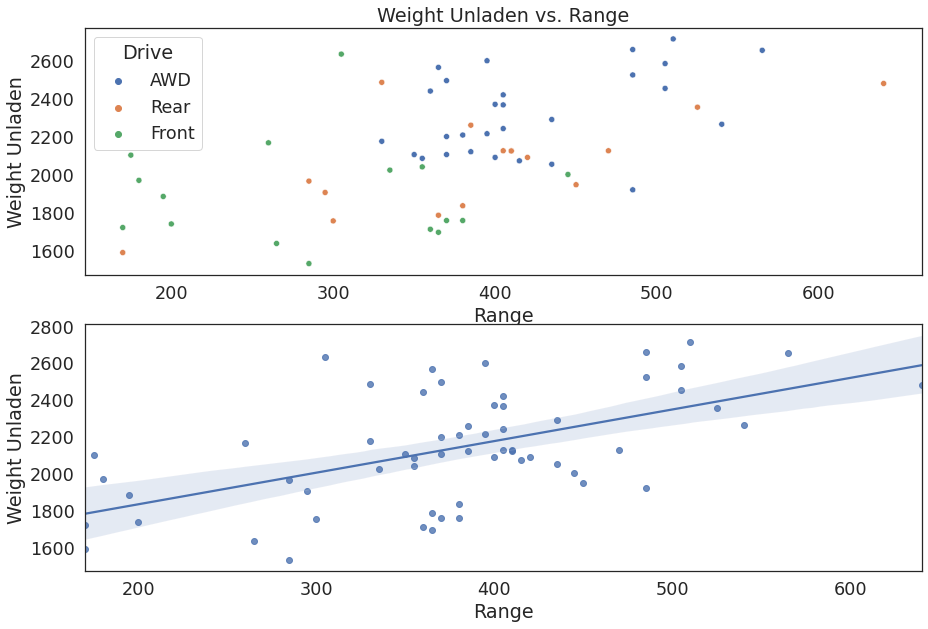

In [33]:
figure, axes = plt.subplots(nrows=2)

sns.scatterplot(data=EDA_df, 
                x='Range', 
                y='Weight Unladen',
                hue='Drive',
               sizes=(20,250),
               ax=axes[0]).set(title = 'Weight Unladen vs. Range')

sns.regplot(data=EDA_df, 
                x='Range', 
                y='Weight Unladen',
                ax=axes[1])
plt.show()